In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
initial_snippet = np.fromfile('/home/mwootten/school/research/average.raw32', dtype=np.dtype('i4'), count=20000)

In [2]:
initial_snippet

array([445, 442, 461, ..., 180, 221, 494], dtype=int32)

In [2]:
diffs = np.diff(initial_snippet)
pd.DataFrame(diffs).describe()

,0
count,19999.000000
mean,0.002450
std,196.944522
min,-3098.000000
25%,-75.000000
50%,-1.000000
75%,79.000000
max,2924.000000


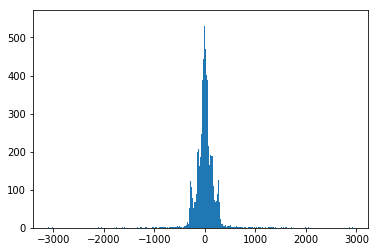

In [15]:
plt.hist(diffs, bins=1000)
plt.show()

In [18]:
len(diffs[abs(diffs) > 100])

8679

In [19]:
len(diffs[abs(diffs) > 200])

3799

Taken from [Stack Overflow](https://stackoverflow.com/questions/22179119/normality-test-of-a-distribution-in-python#22179525)

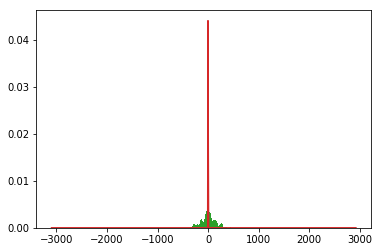

In [5]:
import matplotlib.mlab as mlab
import math

n, bins, patches = plt.hist(diffs, 1000, normed=1)
mu = np.mean(diffs)
sigma = np.std(diffs)
plt.plot(bins, mlab.normpdf(bins, mu, sigma / math.sqrt(20000)))
plt.show()

Okay, so these don't look like they're normally distributed. Back to guess and check.

In [23]:
len(diffs[abs(diffs) > 300])

879

In [24]:
len(diffs[abs(diffs) > 400])

515

In [25]:
len(diffs[abs(diffs) > 500])

386

In [31]:
len(diffs[abs(diffs) > 2000])

10

That seems like a reasonable cutoff to me - it's down to 0.05% of the samples. It's no longer that much worse than the 5 from before.

In [32]:
abs(diffs) > 2000

array([False, False, False, ..., False, False, False], dtype=bool)

Code from https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list#21448251

In [35]:
trigger_times = [i for i, x in enumerate(abs(diffs) > 2000) if x]

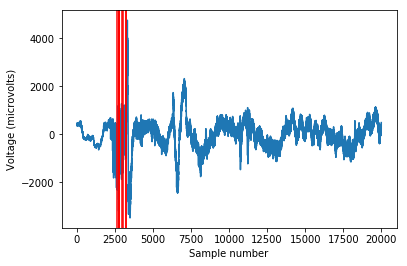

In [40]:
x = np.arange(0, 20000, 1)
y = initial_snippet
plt.plot(x, y)
for t in trigger_times:
    plt.axvline(x=t, color="red")
plt.xlabel('Sample number')
plt.ylabel('Voltage (microvolts)')
plt.show()

That doesn't look encouraging - it looks like a more nuanced approach will be necessary than simply looking at the sample-to-sample change.

In [3]:
def smoother_differences(distance):
    differences = []
    for i in range(len(initial_snippet) - distance):
        differences.append(initial_snippet[i + distance] - initial_snippet[i])
    return differences

In [12]:
diff_20 = np.array(smoother_differences(20))
pd.DataFrame(diff_20).describe()

,0
count,19980.000000
mean,-0.206256
std,321.019836
min,-3630.000000
25%,-170.000000
50%,4.000000
75%,175.000000
max,3464.000000


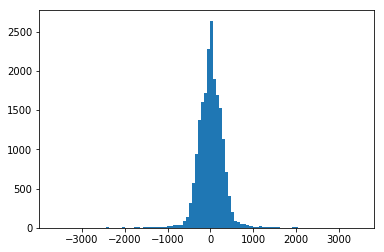

In [8]:
plt.hist(diff_20, bins=100)
plt.show()

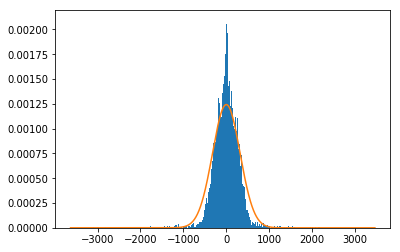

In [10]:
import matplotlib.mlab as mlab
import math

n, bins, patches = plt.hist(diff_20, 1000, normed=1)
mu = np.mean(diff_20)
sigma = np.std(diff_20)
plt.plot(bins, mlab.normpdf(bins, mu, sigma / math.sqrt(1)))
plt.show()

In [30]:
def values_between(arr, minimum, maximum):
    vals = []
    for i in range(len(arr)):
        if minimum <= arr[i] <= maximum:
            vals.append(i)
    return vals

trigger_times = values_between(abs(diff_20), 1500, 2000)
len(trigger_times)

55

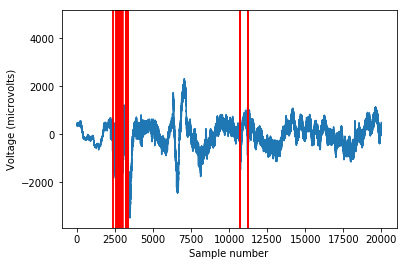

In [31]:
x = np.arange(0, 20000, 1)
y = initial_snippet
plt.plot(x, y)
for t in trigger_times:
    plt.axvline(x=t, color="red")
plt.xlabel('Sample number')
plt.ylabel('Voltage (microvolts)')
plt.show()

Let's parameterize all of this to make it more efficient.

In [32]:
def plot_scenario(distance, minimum, maximum):
    diff = np.array(smoother_differences(distance))
    trigger_times = values_between(diff, minimum, maximum)
    x = np.arange(0, 20000, 1)
    y = initial_snippet
    plt.plot(x, y)
    for t in trigger_times:
        plt.axvline(x=t, color="red")
    plt.xlabel('Sample number')
    plt.ylabel('Voltage (microvolts)')
    plt.show()

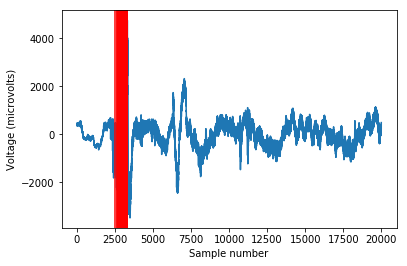

In [35]:
plot_scenario(distance=50, minimum=1500, maximum=9000000)

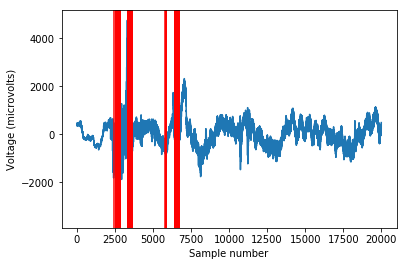

In [38]:
plot_scenario(distance=500, minimum=1500, maximum=9000000)

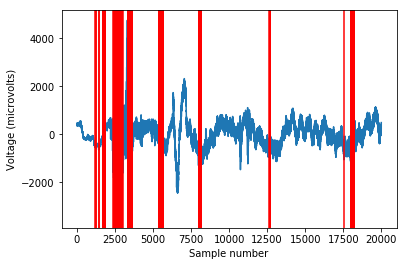

In [43]:
plot_scenario(distance=1500, minimum=1500, maximum=3000)

It's not great, but it's improving. They're spreading out a little more, and with some shifting could probably line up better with the spikes they should be going with. It would probably be better to slope them (for visualization purposes only), but that might take a while.

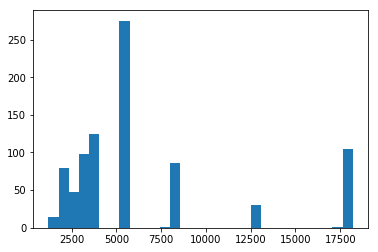

In [41]:
times = values_between(np.array(smoother_differences(1500)), 1500, 9000)
plt.hist(times, bins=30)
plt.show()

In [44]:
len(times)

864

That's still *way* too many spikes, but it looks like they're clustered pretty nicely. I have a solution to the clustering problem in an earlier attempt...

In [47]:
def get_split_points(values, cutoff):
    splits = []
    for i in range(len(values) - 1):
        delta = values[i+1] - values[i]
        if delta > cutoff:
            splits.append(i + 1)
    return splits

In [49]:
splits = get_split_points(times, 100)
splits

In [50]:
spike_times = []
for (start, end) in zip([0] + splits, splits + [len(times)]):
    chunk = times[start:end]
    avg = np.mean(np.array(chunk))
    spike_times.append(int(avg))

In [51]:
spike_times

[1241, 1431, 1806, 2678, 3487, 5538, 8108, 12668, 17548, 18109]

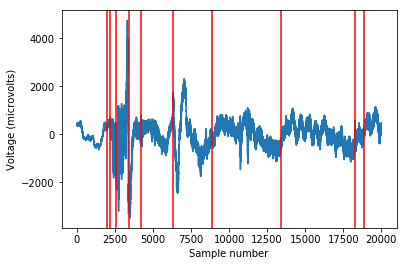

In [53]:
    x = np.arange(0, 20000, 1)
    y = initial_snippet
    plt.plot(x, y)
    for t in spike_times:
        plt.axvline(x=t+750, color="red")
    plt.xlabel('Sample number')
    plt.ylabel('Voltage (microvolts)')
    plt.show()

When shifted 750 to compensate for the backwards shifting, that actually looks okay. Granted, this is a *very* small subsample (20000 samples $\approx$ 53 seconds, of a 5 day sample). However, this looks like it's picking up visual spikes.